<a href="https://colab.research.google.com/github/yexf308/AdvancedMachineLearning/blob/main/Manifold_learning_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pylab inline 
from IPython.display import Image
import numpy.linalg as LA

Populating the interactive namespace from numpy and matplotlib


Some good resources.
- A Mathematical Introduction to Data Science, by Prof. Yao Yuan. [link](https://github.com/yao-lab/yao-lab.github.io/blob/master/book_datasci.pdf)

- Probabilistic Machine Learning: An Introduction, by Kevin Murphy. [link](https://probml.github.io/pml-book/book1.html)

- Course notes from Prof Guangliang Chen. [link](https://www.sjsu.edu/faculty/guangliang.chen/)



# Dimensionality Reduction
## Motivation
Why using unlabeled data?
- labeling is often an “expensive” process. Sometimes it is even not possible. 

- semi(un)-supervised learning is the natural setting for human
learning.

Why dimension reduction?
**Curse of dimensionality**!

**Example:** assume random variable $X$ lives the $D$-dimensional hypercube $[0,1]^D$. If $X$ follows the uniform distribution, it seems that with a reasonably large set of training
data, we could always approximate with $k$-NN. We should be able to find a fairly large set of observations
close to any $x\in [0,1]^D$ and average(classify) them. This approach and our intuition break down in high
dimensions!

In 1D, to get $10\%$ amount of data about $x$, we only need the $10\%$ edge length. In 2D, to get the same amount of $10\%$ amount of data around $x$, we then need a square with area $10\%$ of the total area, whose edge length is $\sqrt{0.1}$. For any $D$, the expected edge length, corresponds to a fraction r of the unit volume will be 
$$e_D(r)=r^{1/D} $$
Already in ten dimensions $e_{10}(0.01) = 0.63$, that is to capture
1% of the data, we must cover 63% of the range of each input
variable. 

**No more ”local” neighborhoods!**

In [ ]:
display(Image(url='https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/knn.png?raw=true', width=500))

### Assumption of Intrinsic dimensionality
Raw format of natural data is often high dimensional, but in
many cases it is the outcome of some process involving only
few degrees of freedom.



## Quick summary

Goal: to **learning a mapping**(also called **embedding**) from the high dimensional visible space $\mathbf{x}\in \mathbb{R}^D$, to a low-dimensional latent space $\mathbf{z}\in \mathbb{R}^d$.

There are two approaches. 
- The mapping can be a parametric model $\mathbf{z}=f(\mathbf{x},\theta)$ which can be applied to any input $\mathbf{x}$. It is a preprocessing step for other kinds of learning algorithms. Methods: **Autoencoder**.
   - we can first reduce the dimensionality by learning a mapping from $\mathbf{x}$ to $\mathbf{z}$ and then
learn a simple linear classifier on this embedding by mapping $\mathbf{z}$ to the target variable $y$.

- it can be a nonparametric mapping where we compute an embedding $\mathbf{z}_n$ for each input $\mathbf{x}_n$ in the data
set, but not for any other points. It is mostly used for **data visualization**, unsupervised learning and preprocessing step for supervised learning as well. Methods: **Manifold Learning (MDS, Kernel PCA, Isomap, Laplacian Eigenmaps)** and so on.


# Typical examples of dimension reduction
- Suppose we are given points in a very high dimensional space $\{\mathbf{x}^{(i)}\}_{i=1}^N\in \mathbb{R}^D$, with some kind of distance $\ell_{ij} =\|\mathbf{x}^{(i)}- \mathbf{x}^{(j)} \|$. We
would like to find low dimensional representations $\{\mathbf{z}^{(i)}\}_{i=1}^N\in \mathbf{R}^d$ for some $d<D$, which can (approximately) preserve the given distances.
  - a set of 1000 3d-points sampled from the 2d **Swiss roll** manifold. The challenge of the
Swiss roll consists of finding a two-dimensional embedding that “unrolls” it

  - a set of 1797 64-dimensional points sampled from the UCI digits dataset.


- If the points are known to lie on a manifold (curve, surface,
etc.), then one can use geodesic distance (shortest distance along the manifold) and try to preserve them in a low-dimensional Euclidean space.

- Given the distances between 10 cities in the world, display
them on a (two-dimensional) map to preserve, as closely as possible, all the distances.

In [ ]:
from sklearn.datasets import make_swiss_roll
import plotly.express as px

n_samples = 1000
noise = 0.05
X, color = make_swiss_roll(n_samples, noise=noise)
fig =  px.scatter_3d(x=X[:, 0], y=X[:, 1], z=X[:, 2], color=color, size=5*ones(1000))
fig.show()



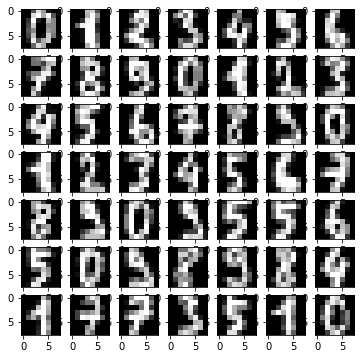

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits() 

X = digits.data
y = digits.target # 0..9
n_samples, n_features = X.shape

fig, axs = plt.subplots(7, 7,figsize=(6,6))
axs = axs.ravel()
for i in range(49):
  axs[i].imshow(X[i].reshape([8,8]), cmap=pyplot.get_cmap('gray'))

In [ ]:
display(Image(url='https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/manifold_learning.png?raw=true', width=600))
display(Image(url='https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/distance_cities.png?raw=true', width=600))


# Manifold Learning
Most “naturally occuring” high dimensional dataset lie a low dimensional structure. We want to recover the underlying low-dimensional structure in a high-dimensional dataset. This structure is often assumed to be a curved manifold.
This is called the
**manifold hypothesis**. 

## What is Manifold
A **manifold** is a topological space which is locally **Euclidean**. For example, the
Earth is spherical but looks flat on the human scale.

A $d$-dimensional manifold $\mathcal{M}$ is a space in which each point $\mathbf{x}\in \mathcal{M}$ has a neighborhood
which is topologically equivalent to a $d-$dimensional Euclidean space, called **tangent space**, denote as $T_{\mathbf{x}}\mathcal{M}$.

### Definition of Manifolds
- A $d$-dimensional manifold 
$$\mathcal{M}= \cup_{\alpha} U_{\alpha}$$
is a mathematical object that generalizes domains in $\mathbb{R}^d$. 
Each one of the chart $U_{\alpha}$ which cover $\mathcal{M}$ is endowed with a system of coordinates.
$$\varphi_\alpha : U_\alpha\rightarrow \mathbb{R}^d  $$

- If two charts $U_\alpha$ and $U_\beta$ overlap, the transition map $\tau_{\alpha, \beta}: \varphi_\alpha(U_\alpha \cap U_\beta)\rightarrow \varphi_\beta(U_\alpha \cap U_\beta)$ is $\tau_{\alpha, \beta} =\varphi_\beta \circ \varphi_\alpha^{-1}$ and smooth. 

- The Riemannian Manifold inherits from its local system of
coordinates, most geometrical notions available on $\mathbb{R}^d$:  metrics,
angles, volumes, etc

- Since each point $\mathbf{x}$ over $\mathcal{M}$ is equipped with a local system of coordinates in $\mathbb{R}^d$
(its tangent space), all differential operators
defined on functions over $\mathbf{R}^d$, can be extended to analogous operators on functions over $\mathcal{M}$.
   - Gradient: $\nabla f(\mathbf{x}) =(\frac{\partial }{\partial x_1}f(\mathbf{x}), \dots ,\frac{\partial }{\partial x_d}f(\mathbf{x}))\rightarrow \nabla_\mathcal{M}f(\mathbf{x})$.
   - Laplacian: $\Delta f(\mathbf{x}) =-\frac{\partial^2}{\partial x_1^2}f(\mathbf{x}) -\dots --\frac{\partial^2}{\partial x_d^2}f(\mathbf{x})\rightarrow \Delta_\mathcal{M}f(\mathbf{x})$ 


- Manifold model with the noise. Then data points no longer lie on the manifold: instead fly nearby. **Projection**!

In [ ]:
display(Image(url='https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/Tangent.png?raw=true', width=500))

# Distance Preservation
**Distance preservation** is the first criterion used to achieve
dimensionality reduction in a nonlinear way. 

In the ideal case, the preservation of the pairwise distances measured in a data set ensures that the low-dimensional embedding inherits the main geometric properties of data, like the global shape or the local neighborhood relationships. Unfortunately, in the nonlinear case, distances cannot be perfectly preserved. 

So most distance-preserving nonlinear dimension reduction algorithms that are described by pairwise distances. 




## Type of distance
- Spatial distances: only the coordinates of the two points matter!
   
  Assuming that the finite set of
indexed points, denoted as $\{\mathbf{x}^{(i)}\}_{i=1}^N$, then the distance between the two points $\mathbf{x}^{(i)}, \mathbf{x}^{(j)}$ normally written as $d(\mathbf{x}^{(i)}, \mathbf{x}^{(j)})$, can be shortened and noted as $\ell_{ij}$. Then $L=\{\ell_{ij}\}$ is the pairwise distance matrix. 
   - Euclidean distance $l_2$

   - Manhattan/Cityblock distance $l_1$

   - Chebyshev/maximum coordinate difference $l_{\infty}$

   - Minkowski distance $l_{p}$

   -  Mahalanobis distance $d(\mathbf{x},\mathbf{y})=\sqrt{(\mathbf{x}-\mathbf{y})^\top S^{-1}(\mathbf{x}-\mathbf{y})}$. 

- Geodesic distance (along curved dimensions)

  We will get back to it later.    

